# Installation
Full installation instructions can be found [here](https://github.com/dafyddstephenson/C-Star/tree/python_package/cstar_ocean/README.md) (`README.md` in the parent directory)


In [1]:
import os
import cstar_ocean as cstar

# Introduction to C-Star "v0" with the `roms_marbl_example` Case

In this notebook we will take a look at the `roms_marbl_example` C-Star case. We can instantiate a C-Star case either from a blueprint (`.yaml` file) or by manually setting it up. Here we'll build a C-Star case from scratch to demonstrate the various structures in C-Star, then we can export the Case to a blueprint-style YAML file.


## Overview of C-Star structures
- A `Case` (`cstar.Case`) is the primary object of C-Star. It contains all the necessary information for a user to run a reproducable Earth system simulation. A Case is built from Components (`cstar.Component`), each representing a specific configuration of a model of one part of the overall system being simulated. In this notebook we'll be working with an ocean circulation component and a biogeochemistry component.
    - **A `Component` object**, meanwhile, consists of, at least, a base model (`cstar.BaseModel`), and optionally additional code (`cstar.AdditionalCode`), input datasets (`cstar.InputDataset`), and discretization information needed to run the base model in the specific configuration in question. In the simplest scenario, we can imagine a Case consisting of a single Component which is just a base model in an bundled example configuration (like an ocean double gyre) run in serial with bundled initial and forcing data (i.e. no additional code, input datasets, or parallelization information needed).
        - **A `BaseModel` object** describes the "off-the-shelf" model underlying a Component. It does not contain any information relative to the specific domain, forcing, code modifications, or combination of parameters with which the model will be run in our particular use case. Typically it will simply point (using the `source_repo` attribute) to the repository in which a development team hosts a model (in this case the ROMS and MARBL source code repositories), and features a `checkout_target` attribute instructing C-Star on which version of this source code to use.
        - **An `AdditionalCode` object** also points to a repository, this time containing code that is necessary to run the base model _in a particular configuration_ of interest. This may include runtime namelist files specifying parameter values and paths to input data, or compile-time option files or source-code modifications. This is effectively code that would not normally be included with a model, but is required in order to run it. The object contains a `base_model` attribute pointing to the `BaseModel` object with which this code is associated/should be compiled (telling C-Star, e.g., this is a namelist file to be used by the MARBL base model).
        - **An `InputDataset` object** is a descriptor of any non-plaintext file needed to run our base model in a particular configuration. These are typically netCDF files describing the domain, initial conditions, surface and boundary forcing of a particular simulation we'd like to run using the base model. The object contains a `base_model` attribute pointing to the `BaseModel` object with which this data is associated (telling C-Star, e.g., this is a surface forcing file to be used by the ROMS base model).

- You can find more information on C-Star `Case`, `Component`, `BaseModel`, `AdditionalCode`, and `InputDataset` objects by querying, e.g., `cstar.Component?` in a cell.

## The structure of the Case:
The `roms_marbl_example` case structure breaks down like this:  
```
Case
├── MARBLComponent
│   ├── MARBLBaseModel
│   └── AdditionalCode
└── ROMSComponent
    ├── ROMSBaseModel
    ├── AdditionalCode
    ├── InputDatasets
    └── <dicretisation_information>

```
You will notice that the `Component` and `BaseModel` objects here are specific to the object they describe (e.g. `ROMSBaseModel`). This is because there may be some unique attributes or operations associated with a `BaseModel` object describing ROMS that may be different to those describing another base model such as MARBL, which has its own subclass `MARBLBaseModel`.

To build this case from the bottom up, we'll need to first build `BaseModel` objects for ROMS and MARBL

## Constructing the BaseModel objects
To initialize a `BaseModel` object (see `cstar.BaseModel?`), we need a `source_repo` (repository URL containing the base model source code) and a `checkout_target` (a point in the repository history we'd like to jump to). For ROMS we'll use my fork at the latest commit hash. For MARBL we'll use v0.45, around which the ROMS-MARBL driver was built:

In [2]:
#BaseModel object, ROMS:

roms_base_model=cstar.ROMSBaseModel(
                           source_repo='https://github.com/CESR-lab/ucla-roms.git',
                           checkout_target='2a4e9107ffc771d2833fbea3e08f1e169759b5ff')

marbl_base_model=cstar.MARBLBaseModel(
                            source_repo='https://github.com/marbl-ecosys/MARBL.git',
                            checkout_target='marbl0.45.0')

In [3]:
roms_base_model

ROMSBaseModel object 
---------------------
source_repo = https://github.com/CESR-lab/ucla-roms.git (default)
checkout_target = 2a4e9107ffc771d2833fbea3e08f1e169759b5ff
local_config_status=3 (Environment variable ROMS_ROOT is not present and it is assumed the base model is not installed locally)

In [4]:
marbl_base_model

MARBLBaseModel object 
----------------------
source_repo = https://github.com/marbl-ecosys/MARBL.git (default)
checkout_target = marbl0.45.0 corresponding to hash 6e6b2f7c32ac5427e6cf46de4222973b8bcaa3d9
local_config_status=3 (Environment variable MARBL_ROOT is not present and it is assumed the base model is not installed locally)

When we query the BaseModel objects we see that C-Star was unable to locate a local installation of both models (`local_config_status`). We could install these models now using `BaseModel.get()` on each one, but we will instead set everything up together after building the case using a single call to `Case.setup()`.

Note also that MARBL's source repo is marked as `(default)`, whereas ROMS' isn't, as we are using a fork, rather than the official repository.

## Constructing the AdditionalCode objects
### MARBL
Similarly to a `BaseModel` object, we need to provide a `source_repo` and a `checkout_target` that points to a repository housing the additional code. We also need to provide:
- a `BaseModel` object with which the additional code is associated
- a list of paths relative to the top level of the repository pointing to compile-time files (`source_mods`) and runtime files (`namelists`).

For the MARBL Component, this is pretty straightforward, as we only have a few runtime namelist files, 
e.g. `<REPO_TOP_LEVEL>/namelists/MARBL/marbl_in`:

In [5]:
marbl_additional_code=cstar.AdditionalCode(
                            base_model=marbl_base_model,
                            source_repo='https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example',
                            checkout_target='69ee87b554082c46e3f138a9b3faf17439966e90',
                            namelists=["namelists/MARBL/marbl_in",
                                       "namelists/MARBL/marbl_tracer_output_list",
                                       "namelists/MARBL/marbl_diagnostic_output_list"]
                            )
marbl_additional_code

AdditionalCode object
---------------------
Base model: MARBL
Additional code repository URL: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example (checkout target: 69ee87b554082c46e3f138a9b3faf17439966e90)
Namelist files (paths relative to repository top level):
    namelists/MARBL/marbl_in
    namelists/MARBL/marbl_tracer_output_list
    namelists/MARBL/marbl_diagnostic_output_list

### ROMS
For ROMS, we have both runtime configuration files and compile-time changes to the source code:

In [6]:
roms_additional_code=cstar.AdditionalCode(
                            base_model=roms_base_model,
                            source_repo='https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example',
                            checkout_target='69ee87b554082c46e3f138a9b3faf17439966e90',
                            source_mods=["source_mods/ROMS/bgc.opt",
                                         "source_mods/ROMS/bulk_frc.opt",
                                         "source_mods/ROMS/cppdefs.opt",
                                         "source_mods/ROMS/diagnostics.opt",
                                         "source_mods/ROMS/ocean_vars.opt",
                                         "source_mods/ROMS/param.opt",
                                         "source_mods/ROMS/tracers.opt",
                                         "source_mods/ROMS/Makefile",
                                         "source_mods/ROMS/get_makefile",
                                         "source_mods/ROMS/Make.depend"],
                            namelists=["namelists/ROMS/roms.in_MARBL"]
                                )
roms_additional_code

AdditionalCode object
---------------------
Base model: ROMS
Additional code repository URL: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example (checkout target: 69ee87b554082c46e3f138a9b3faf17439966e90)
Source code modification files (paths relative to repository top level):
    source_mods/ROMS/bgc.opt
    source_mods/ROMS/bulk_frc.opt
    source_mods/ROMS/cppdefs.opt
    source_mods/ROMS/diagnostics.opt
    source_mods/ROMS/ocean_vars.opt
    source_mods/ROMS/param.opt
    source_mods/ROMS/tracers.opt
    source_mods/ROMS/Makefile
    source_mods/ROMS/get_makefile
    source_mods/ROMS/Make.depend
Namelist files (paths relative to repository top level):
    namelists/ROMS/roms.in_MARBL

## Constructing the InputDataset objects
To run this case, we need different types of input dataset, each with a specialized subclass of the `InputDataset` class:
- a grid file supplying information about the domain to ROMS (`ModelGrid`)
- An initial condition file from which to start the run (`InitialConditions`)
- boundary forcing files providing information at the edge of the domain (`BoundaryConditions`)
- surface forcing files providing information at the upper boundary (`SurfaceForcing`)
- tidal forcing files providing information on tidal constituents (`TidalForcing`)

To construct an `InputDataset` object, we need (see `cstar.InputDataset?`):
- a `BaseModel` object with which this input dataset is associated
- a source URL
- a [SHA256 checksum](https://en.wikipedia.org/wiki/Checksum) to verify any downloads

In our case, all the files associated with our `roms_marbl_example` case are stored at https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example. [This online tool](https://emn178.github.io/online-tools/sha256_checksum.html) can be used to check SHA hashes on remote files, `shasum -a 256` can be used locally on a UNIX machine.

In [7]:
#Grid
roms_model_grid=cstar.ModelGrid(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_grd.nc",
                    file_hash="fd537ef8159fabb18e38495ec8d44e2fa1b7fb615fcb1417dd4c0e1bb5f4e41d"
)
# Initial conditions
roms_initial_conditions=cstar.InitialConditions(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/MARBL_rst.20120103120000.nc",
                    file_hash="fc3bbd039256edc89c898efda0eebc5c53773995598d59310bc6d57f454a6ddd"
)
# Tides
roms_tidal_forcing=cstar.TidalForcing(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_tides.nc",
                    file_hash="90db174ab174909f9bf27c13fa19995c03f680bcb80e7d012268505b48590338"
)
# Boundary
roms_phys_boundary_forcing=cstar.BoundaryForcing(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_bry_2012.nc",
                    file_hash="c3b0e14aae6dd5a0d54703fa04cf95960c1970e732c0a230427bf8b0fbbd8bf1"
)
roms_bgc_boundary_forcing=cstar.BoundaryForcing(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_bry_bgc_MARBL.nc",
                    file_hash="897a8df8ed45841a98b3906f2dd07750decc5c2b50095ba648a855c869c7d3ee"
)
# Surface
roms_bgc_surface_forcing=cstar.SurfaceForcing(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_frc_bgc.nc",
                    file_hash="621dd23691d87aa93c5cc582daf6c5f18333ed062ff934777d50b63346c3f84d"
)
roms_phys_surface_forcing=cstar.SurfaceForcing(
                    base_model=roms_base_model,
                    source="https://github.com/CWorthy-ocean/input_datasets_roms_marbl_example/raw/main/roms_frc.201201.nc",
                    file_hash="923049a9c2ab9ce77fa4a0211585e6848a12e87bf237e7aa310f693c3ac6abfa"
)

roms_input_datasets=[roms_model_grid,
                     roms_initial_conditions,
                     roms_tidal_forcing,
                     roms_phys_boundary_forcing,
                     roms_bgc_boundary_forcing,
                     roms_bgc_surface_forcing,
                     roms_phys_surface_forcing]

## Putting it all together to build ROMS and MARBL components:
We now have everything we need to create the `MARBLComponent` and `ROMSComponent` objects that come together to make our Case.
### MARBL:

In [8]:
marbl_component=cstar.MARBLComponent(
                    base_model=marbl_base_model,
                    additional_code=marbl_additional_code
)
marbl_component     

---------------------
MARBLComponent object 
---------------------
Built from: 
1 AdditionalCode repositories (query using ROMSComponent.additional_code)
0 InputDataset objects (query using ROMSComponent.input_datasets

### ROMS
a ROMSComponent object (see `cstar.ROMSComponent?`) is a little more involved, not just because there are more objects going into it. Because we will be running this ROMS simulation in parallel, we should also supply information about how to distribute the domain among CPUs:

In [9]:
roms_component=cstar.ROMSComponent(
                    base_model=roms_base_model,
                    additional_code=roms_additional_code,
                    input_datasets=roms_input_datasets,
                    n_procs_x = 3,
                    n_procs_y = 3)
roms_component    

--------------------
ROMSComponent object 
--------------------
Built from: 
1 AdditionalCode repositories (query using ROMSComponent.additional_code)
7 InputDataset objects (query using ROMSComponent.input_datasets

Discretization info:
time_step: 1
n_procs_x: 3 (Number of x-direction processors)
n_procs_y:3 (Number of y-direction processors)

## And finally, we can build the Case object:
This is instantiated using a list of components, a name string, and a "caseroot" - the local path where the case will be run

In [10]:
roms_marbl_case=cstar.Case(
                        components=[roms_component,marbl_component],
                              name='roms_marbl_example_cstar_case',
                          caseroot=os.getcwd()+'/roms_marbl_example_cstar_case',
                            start_date='20120103 12:00:00',
                              end_date='20120131 12:00:00')
roms_marbl_case

/Users/dafyddstephenson/Code/my_c_star/cstar_ocean/cstar_case.py:107: RuntimeWarning: Valid start date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(
/Users/dafyddstephenson/Code/my_c_star/cstar_ocean/cstar_case.py:123: RuntimeWarning: Valid end date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(


------------------
C-Star case object 
------------------
Name: roms_marbl_example_cstar_case
caseroot: /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case
start_date: 2012-01-03 12:00:00
end_date: 2012-01-31 12:00:00
Is setup: False
Valid date range:
valid_start_date: None
valid_end_date: None


It is built from the following Component base models (query using Case.components): 
   ROMS
   MARBL

## Setting the Case up
We can see from querying the `roms_marbl_case` object above (`Is setup: False`) that the case has not yet been set up locally. When a Case object is instantiated, it runs the `Case.check_is_setup()` method, checking the `caseroot` directory.

To set the case up, we run `roms_marbl_case.setup()`, which performs a series of actions:
- check the base model has been installed and, if not, ask the user if they would like to:
  - download ROMS and compile `Tools-Roms` and `NHMG`
  - download and compile MARBL
- retrieve any additional code using `AdditionalCode.get()`
- retrieve any input datasets using `InputDataset.get()`

When the base models are installed, a file `cstar_local_config.py` will be created (or appended to) defining the user's environment such that these base models are available on your machine next time you import C-Star.

In [ ]:
roms_marbl_case.setup()
# Cell output showing long streams of STDOUT and STDERR has been cleared.

Before compiling and running the case, let's take a look at the structure of the caseroot directory that we have set up

In [12]:
# Write the caseroot to a bash variable so we can use tree in a bash cell:
os.environ['roms_marbl_caseroot']=roms_marbl_case.caseroot

In [13]:
%%bash
tree $roms_marbl_caseroot

/Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case
├── input_datasets
│   └── ROMS
│       ├── MARBL_rst.20120103120000.nc
│       ├── roms_bry_2012.nc
│       ├── roms_bry_bgc_MARBL.nc
│       ├── roms_frc.201201.nc
│       ├── roms_frc_bgc.nc
│       ├── roms_grd.nc
│       └── roms_tides.nc
├── namelists
│   ├── MARBL
│   │   ├── marbl_diagnostic_output_list
│   │   ├── marbl_in
│   │   └── marbl_tracer_output_list
│   └── ROMS
│       └── roms.in_MARBL
└── source_mods
    └── ROMS
        ├── Make.depend
        ├── Makefile -> get_makefile
        ├── bgc.opt
        ├── bulk_frc.opt
        ├── cppdefs.opt
        ├── diagnostics.opt
        ├── get_makefile
        ├── ocean_vars.opt
        ├── param.opt
        └── tracers.opt

8 directories, 21 files


## Saving the Case to a YAML file
We can save all the information associated with this case to a YAML file using `Case.persist(filename)`
If we want to run this exact Case again, we can use the `Case.from_blueprint(filename)` method:

In [15]:
roms_marbl_case.persist(roms_marbl_case.caseroot+'/roms_marbl_case.yaml')

In [16]:
%%bash
cat $roms_marbl_caseroot/roms_marbl_case.yaml

registry_attrs:
  name: roms_marbl_example_cstar_case
components:
- component:
    base_model:
      name: ROMS
      source_repo: https://github.com/CESR-lab/ucla-roms.git
      checkout_target: 2a4e9107ffc771d2833fbea3e08f1e169759b5ff
    discretization:
      nx: null
      ny: null
      n_levels: null
      n_procs_x: 3
      n_procs_y: 3
      time_step: 1
    additional_code:
      source_repo: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example
      checkout_target: 69ee87b554082c46e3f138a9b3faf17439966e90
      source_mods:
      - source_mods/ROMS/bgc.opt
      - source_mods/ROMS/bulk_frc.opt
      - source_mods/ROMS/cppdefs.opt
      - source_mods/ROMS/diagnostics.opt
      - source_mods/ROMS/ocean_vars.opt
      - source_mods/ROMS/param.opt
      - source_mods/ROMS/tracers.opt
      - source_mods/ROMS/Makefile
      - source_mods/ROMS/get_makefile
      - source_mods/ROMS/Make.depend
      namelists:
      - namelists/ROMS/roms.in_MARBL
    input_datasets:


## Compiling the Case
Now we have all of the necessary code and data to run the case, we can compile it using `roms_marbl_case.build()`

In [ ]:
roms_marbl_case.build()
# Cell output showing long streams of STDOUT and STDERR has been cleared.

## Running the Case
There are three stages to this:
- `roms_marbl_case.pre_run()` performs pre-processing steps such as partitioning input datasets
- `roms_marbl_case.run()` calls the executable that we created with `roms_marbl_case.build()`
- `roms_marbl_case.post_run()` performs post-processing steps such as joining output datasets (which are output in tiles, one per processor)

In [18]:
roms_marbl_case.pre_run()
# Cell output showing long streams of STDOUT and STDERR has been cleared.


     NP_XI =  3    NP_ETA =  3

 Processing netCDF file '../roms_grd.nc'...
 allocated book-keeping arrays, maxdims =  5 maxvars = 19
    Created partitioned file 'roms_grd.0.nc'.
    Created partitioned file 'roms_grd.1.nc'.
    Created partitioned file 'roms_grd.2.nc'.
    Created partitioned file 'roms_grd.3.nc'.
    Created partitioned file 'roms_grd.4.nc'.
    Created partitioned file 'roms_grd.5.nc'.
    Created partitioned file 'roms_grd.6.nc'.
    Created partitioned file 'roms_grd.7.nc'.
    Created partitioned file 'roms_grd.8.nc'.
 allocated nf_char workspace           1
 allocated nf_double workspace         196
 allocated nf_double workspace         676
                     var   1 out of  19 non-part.  non-rec. 'spherical'.
                     var   2 out of  19 partitioned array 'angle'
                     var   3 out of  19 partitioned array 'h'
                     var   4 out of  19 partitioned array 'hraw'
                     var   5 out of  19 partitioned array 

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 ..........output

 cpu time =       0.53 sec


 Analysis/file creation :                              0.04 sec
        Total data read :       60.60 MBytes in        0.01 sec (10100.66 MB/sec)
     Total data written :       60.62 MBytes in        0.00 sec (15155.56 MB/sec)
   Array splitting time :                              0.01 sec
  Output file sync time :                              0.47 sec
              Gray time :                              0.00 sec
                                               ------------------
            Elapsed wall-clock time:                   0.53 sec


     NP_XI =  3    NP_ETA =  3

 Processing netCDF file '../roms_bry_bgc_MARBL.nc'...
 allocated book-keeping arrays, maxdims =  8 maxvars =137
    Created partitioned file 'roms_bry_bgc_MARBL.0.nc'.
    Created partitioned file 'roms_bry_bgc_MARBL.1.nc'.
    Created partitioned file 'roms_bry_bgc_MARBL.2.nc'.
    Created partitioned file 'roms_bry_bgc_MARBL.3.nc'.
    Created partitioned file 'ro

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


     0.1 rec     110 out of     744 ...
     0.1 rec     111 out of     744 ...
     0.1 rec     112 out of     744 ...
     0.1 rec     113 out of     744 ...
     0.1 rec     114 out of     744 ...
     0.1 rec     115 out of     744 ...
     0.1 rec     116 out of     744 ...
     0.1 rec     117 out of     744 ...
     0.1 rec     118 out of     744 ...
     0.1 rec     119 out of     744 ...
     0.1 rec     120 out of     744 ...
     0.1 rec     121 out of     744 ...
     0.1 rec     122 out of     744 ...
     0.1 rec     123 out of     744 ...
     0.1 rec     124 out of     744 ...
     0.1 rec     125 out of     744 ...
     0.1 rec     126 out of     744 ...
     0.1 rec     127 out of     744 ...
     0.1 rec     128 out of     744 ...
     0.1 rec     129 out of     744 ...
     0.2 rec     130 out of     744 ...
     0.2 rec     131 out of     744 ...
     0.2 rec     132 out of     744 ...
     0.2 rec     133 out of     744 ...
     0.2 rec     134 out of     744 ...


In [19]:
roms_marbl_case.run()
# Cell output showing long streams of STDOUT and STDERR has been cleared.


 Activated CPP configuration switches:
 <cppdefs.opt>
       ROMS_MARBL_EXAMPLE      CURVGRID                SPHERICAL
       MASKING                 BULK_FRC                EXACT_RESTART
       SPONGE                  UV_VIS2                 TS_DIF2
       SOLVE3D                 UV_ADV                  UV_COR
       SALINITY                NONLIN_EOS              SPLIT_EOS
       TIDES                   LMD_MIXING              LMD_KPP
       LMD_BKPP                LMD_RIMIX               LMD_CONVEC
       LMD_NONLOCAL            IMPLICIT_BOTTOM_DRAG    OBC_M2FLATHER
       OBC_M3ORLANSKI          OBC_TORLANKSI           OBC_WEST
       OBC_EAST                OBC_NORTH               OBC_SOUTH
       Z_FRC_BRY               M2_FRC_BRY              M3_FRC_BRY
       T_FRC_BRY               MARBL                   MARBL_DIAGS
       NOX_FORCING             NHY_FORCING             PCO2AIR_FORCING
 <pre_step3d4S.F>
       SPLINE_UV               SPLINE_TS
 <step3d_uv1.F>
       UPSTREAM

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


In [20]:
roms_marbl_case.post_run()
# Cell output showing long streams of STDOUT and STDERR has been cleared.

/Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.20120106120000.0.nc
 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.20120106120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.20120106120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.20120106120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.20120106120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_rst.201201061200

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120114120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120114120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120114120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120114120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120114120000.4.nc  i,jSW =   10   10
                                5 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120119120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120119120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120119120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120119120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120119120000.4.nc  i,jSW =   10   10
                                5 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 allocated "buff" with  max_buff_size =                 8100
 allocated "bfr_out" with max_bfr_out =                67600
     0.1 Processing record       1 out of       2 ...
                Copy non-partitioned array: 'ocean_time'...
                Copy non-partitioned array: 'time_step'...
                Assembly partitioned array type  3 name = 'zeta'
                Assembly partitioned array type  3 name = 'ubar'
                Assembly partitioned array type  3 name = 'vbar'
                Assembly partitioned array type  3 name = 'MARBL_PH_3D'
                Assembly partitioned array type  3 name = 'MARBL_PH_3D_ALT_CO2'
                Assembly partitioned array type  3 name = 'MARBL_PH_SURF'
                Assembly partitioned array type  3 name = 'MARBL_ABIO_PH_SURF'
                Assembly partitioned array type  3 name = 'MARBL_PH_SURF_ALT_CO2'
                Assembly partitioned array type  3 name = 'u'
                Assembly partitioned array type  3 name = 'v'

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120103120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120103120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120103120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120103120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120103120000.4.nc  i,jSW =   10   10
                                5 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120125120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120125120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120125120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120125120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120125120000.4.nc  i,jSW =   10   10
                                5 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


 Processing set of    9 files   0 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120120120000.0.nc  i,jSW =    1    1
                                1 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120120120000.1.nc  i,jSW =   10    1
                                2 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120120120000.2.nc  i,jSW =   18    1
                                3 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120120120000.3.nc  i,jSW =    1   10
                                4 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_cstar_case/output/PARTITIONED/MARBL_his.20120120120000.4.nc  i,jSW =   10   10
                                5 /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


     0.1 Processing record       3 out of       4 ...
                Copy non-partitioned array: 'ocean_time'...
                Copy non-partitioned array: 'time_step'...
                Assembly partitioned array type  3 name = 'zeta'
                Assembly partitioned array type  3 name = 'ubar'
                Assembly partitioned array type  3 name = 'vbar'
                Assembly partitioned array type  3 name = 'u'
                Assembly partitioned array type  3 name = 'v'
                Assembly partitioned array type  3 name = 'temp'
                Assembly partitioned array type  3 name = 'salt'
     0.1 Processing record       4 out of       4 ...
                Copy non-partitioned array: 'ocean_time'...
                Copy non-partitioned array: 'time_step'...
                Assembly partitioned array type  3 name = 'zeta'
                Assembly partitioned array type  3 name = 'ubar'
                Assembly partitioned array type  3 name = 'vbar'
          

## A quick look at the output
The output of the case consists of 4 file types:
- `MARBL_bgc.20120103120000.nc` contains the 32 BGC tracers
- `MARBL_bgc_dia.20120103120000.nc` contains 343 BGC diagnostics
- `MARBL_his.201201??120000.nc` contains ocean physics variables
- `MARBL_rst.201201??120000.nc` are restart files

In [18]:
ls /Users/dafyddstephenson/Code/my_c_star/cstar_ocean/roms_marbl_example_cstar_case/output/

MARBL_bgc.20120103120000.nc      MARBL_rst.20120104120000.nc
MARBL_bgc_dia.20120103120000.nc  MARBL_rst.20120105120000.nc
MARBL_his.20120103120000.nc      MARBL_rst.20120106120000.nc
MARBL_his.20120104120000.nc      MARBL_rst.20120107120000.nc
MARBL_his.20120105120000.nc      MARBL_rst.20120108120000.nc
MARBL_his.20120106120000.nc      MARBL_rst.20120109120000.nc
MARBL_his.20120107120000.nc      MARBL_rst.20120110120000.nc
MARBL_his.20120108120000.nc      MARBL_rst.20120111120000.nc
MARBL_his.20120109120000.nc      MARBL_rst.20120112120000.nc
MARBL_his.20120110120000.nc      MARBL_rst.20120113120000.nc
MARBL_his.20120111120000.nc      MARBL_rst.20120114120000.nc
MARBL_his.20120112120000.nc      MARBL_rst.20120115120000.nc
MARBL_his.20120113120000.nc      MARBL_rst.20120116120000.nc
MARBL_his.20120114120000.nc      MARBL_rst.20120117120000.nc
MARBL_his.20120115120000.nc      MARBL_rst.20120118120000.nc
MARBL_his.20120116120000.nc      MARBL_rst.20120119120000.nc
MARBL_his.20120117120000

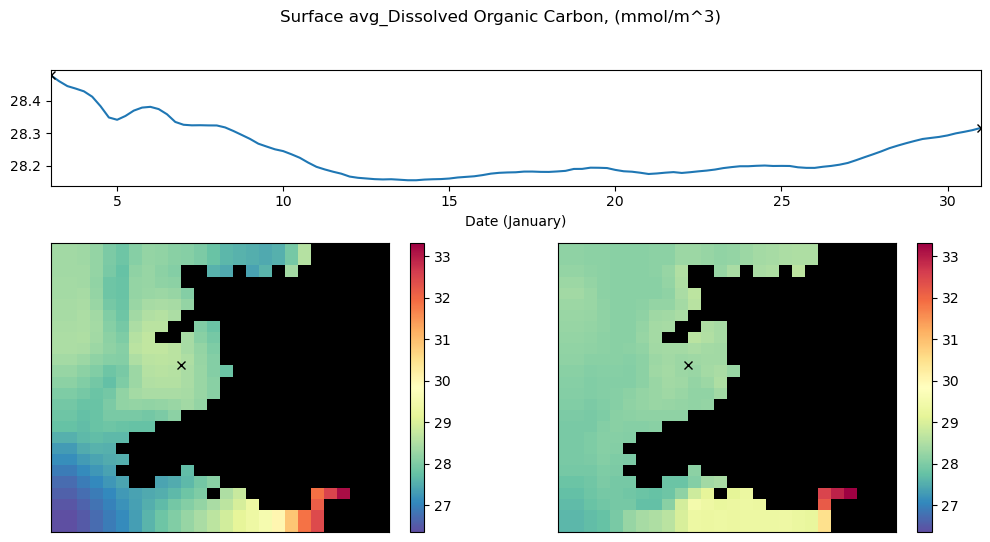

In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

######################################################
BGC_DS=xr.open_dataset(roms_marbl_case.caseroot+'/output/MARBL_bgc.20120103120000.nc')
var='DOC'
BGC_DA=BGC_DS[var].isel(s_rho=99)
######################################################

fig = plt.figure()
CMAP=plt.colormaps['Spectral_r'].__copy__()
CMAP.set_under('k')

gs = GridSpec(3, 2, figure=fig,hspace=0.5)
ax1 = fig.add_subplot(gs[0, :])

ax2 = fig.add_subplot(gs[1:,0])
ax3 = fig.add_subplot(gs[1:,1])

VMIN=np.min(BGC_DA.values[BGC_DA.values>0])
VMAX=np.max(BGC_DA.values[BGC_DA.values>0])

p2=ax2.pcolormesh(BGC_DA.isel(time=0).values,vmin=VMIN,vmax=VMAX,cmap=CMAP)
p3=ax3.pcolormesh(BGC_DA.isel(time=-1 ).values,vmin=VMIN,vmax=VMAX,cmap=CMAP)
[a.set_xticks([]) for a in [ax2,ax3]]
[a.set_yticks([]) for a in [ax2,ax3]]
ax2.plot(10,15,'kx')
ax3.plot(10,15,'kx')

ax1.plot(3+BGC_DA.time*3600*6/86400,BGC_DA[:,15,10])
ax1.set_xlim(3,31)
ax1.set_xlabel('Date (January)')
#ax1.set_ylim(VMIN,VMAX)
ax1.plot(3+BGC_DA.time[0]*3600*6/86400,BGC_DA[0,15,10],'kx')
ax1.plot(3+BGC_DA.time[-1]*3600*6/86400,BGC_DA[-1,15,10],'kx')
fig.colorbar(p2,ax=ax2)
fig.colorbar(p3,ax=ax3)

fig.suptitle('Surface '+BGC_DS[var].long_name+', ('+BGC_DS[var].units+')')
fig.set_size_inches(12,6)

The "X" in this plot highlights the point whose time series is plotted in the top panel. The lower left panel represents the first snapshot (January 3rd) and the lower right panel represents the final snapshot (January 31st)